# 4.2 SU Asset Distribution

- [1 Functions](#1-Functions)
- [2 Data](#2-Data)
- [3 지니계수 계산 및 선행연구와 비교](#3-지니계수-계산-및-선행연구와-비교)
- [4 Net Worth in 2022](#4-Net-Worth-in-2022)
- [5 Income in 2022](#5-Income-in-2022)
- [6 Income in 2022 with Log-normal](#6-Income-in-2022-with-Log-normal)
- [부록: scipy.opt.minimize 사용법](#부록:-scipy.opt.minimize-사용법)

## 1 Functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

### SU

**PDF**

In [2]:
def SU_pdf(x, m, s, lambda_, theta):

    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

**Log Likelihood Function**

`s`($s$)와 `theta`($\theta$)가 항상 양수이기 때문에 최적화 과정에서 이 조건을 부과하기 위해 이들 파라미터에 지수(natural exponential)를 취해서 로그가능도 함수를 만드는 방법을 사용한다. 이렇게 하면 입력 파라미터는 제약(bounding) 조건이 사라지고 모든 실수값을 취할 수 있게 된다.

In [3]:
def weight_ll_SU_e(x, weight, m, s, lambda_, theta):

    s = np.exp(s)
    theta = np.exp(theta)
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta

    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

**MLE Objective Function**

In [4]:
def weight_obj_SU_e(params, *args):

    m, s, lambda_, theta = params
    (x, weight) = args
    
    log_lik_val = weight_ll_SU_e(x, weight, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

**Mean and Variance**

In [5]:
def SU_mean(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    mean = m + s*w**(0.5)*np.sinh(lambda_)

    return mean

def SU_var(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    variance = 0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1) 

    return variance

def SU_skew(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_3 = 0.25*(s**3)*w**(0.5)*(w-1)**2*(w*(w+2)*np.sinh(3*lambda_)+3*np.sinh(lambda_))
    skewness = mu_3/(sigma**3)
        
    return skewness

def SU_kurt(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_4 = 0.125*(s**4)*(w-1)**2*((w**2)*(w**4+2*w**3+3*w**2-3)*np.cosh(4*lambda_)
                                  + 4*(w**2)*(w+2)*np.cosh(2*lambda_) 
                                  + 3*(2*w+1))
    kurtosis = mu_4/(sigma**4)
        
    return kurtosis

**CDF and PPF**

- PPF stands for Probability Point Function. The PPF is the inverse of the CDF (cumulative distribution function). It returns the exact point where the probability of everything to the left is equal to y.

In [6]:
def SU_cdf(x, m, s, lambda_, theta):
    
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
    prob  = st.norm.cdf(z) 

    return prob

def SU_ppf(prob, m, s, lambda_, theta):
    
    x  = np.sinh(st.norm.ppf(prob)*theta + lambda_)*s + m

    return x

**Lorenz Curve**

In [7]:
def Lorenz_SU(p, m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    v = (np.exp(lambda_)*st.norm.cdf(st.norm.ppf(p) - theta)
         - np.exp(-lambda_)*st.norm.cdf(st.norm.ppf(p) + theta))
    num = m*p + 0.5*s*w**0.5*v
    den = m + s*w**0.5*np.sinh(lambda_)
    Lorenz  = num/den

    return Lorenz

### Log-normal

**PDF**

In [8]:
def LN_pdf(x, mu, sigma):

    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

**Log Likelihood Function**

In [9]:
def weight_ll_LN_e(x, weight, mu, sigma):

    sigma = np.exp(sigma)
    
    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma

    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

**MLE Objective Function**

In [10]:
def weight_obj_LN_e(params, *args):

    mu, sigma = params
    (x, weight) = args
    
    log_lik_val = weight_ll_LN_e(x, weight, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

**Mean and Variance**

$$
\text{Mean:  }\exp\left(\mu + \frac{\sigma^2}{2}\right)
$$

$$
\text{Variance:  }\left[\exp(\sigma^2) - 1\right] \exp\left(2\mu + \sigma^2\right)
$$

In [11]:
def LN_mean(mu, sigma):
    
    mean = np.exp(mu + sigma**2/2)

    return mean

def LN_var(mu, sigma):
    
    variance = (np.exp(sigma**2) - 1)*np.exp(2*mu + sigma**2) 

    return variance

def LN_skewness(mu, sigma):
    
    skewness = (np.exp(sigma**2) + 2) * np.sqrt(np.exp(sigma**2) - 1)
    
    return skewness

def LN_kurtosis(mu, sigma):
    
    kurtosis = np.exp(4*sigma**2) + 2*np.exp(3*sigma**2) + 3*np.exp(2*sigma**2) - 3
    
    return kurtosis 

**CDF and PPF**

In [12]:
def LN_cdf(x, mu, sigma):
    
    z = (np.log(x) - mu)/sigma
    prob  = st.norm.cdf(z) 

    return prob

def LN_ppf(prob, mu, sigma):
    
    x  = np.exp(st.norm.ppf(prob)*sigma + mu)

    return x

**Lorenz Curve**

$$
L(p) = \Phi\left(\Phi^{-1}(p) - \sigma\right)
$$

In [13]:
from scipy.stats import norm

def Lorenz_LN(p, sigma):
    Phi_inv = norm.ppf(p)  # Φ^{-1}(p), 표준정규분포의 CDF의 역함수
    L_p = norm.cdf(Phi_inv - sigma)
    return L_p

## 2 Data

- [Survey of Consumer Finances (SCF)](https://www.federalreserve.gov/econres/scfindex.htm)
- [Code Book](https://sda.berkeley.edu/sdaweb/analysis/?dataset=scfcomb2022)


미국은 SCF가 3년 주기로 행해지는데, 2022년 SCF의 경우, [2022년 4월부터 2023년 3월까지 본 조사(main survey)가 행해졌고](https://www.aeaweb.org/forum/1850/survey-consumer-finances-invites-comments-proposed-approach), 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 조사 시점을 기준으로 조사됐다. SCF 보고서는 모든 금액에 대해 CPI를 사용해 인플레이션 효과를 제거한 숫자를 사용해 분석하는 반면, (관측별 가중치를 제공하지만) 가중 평균 등은 사용하지 않는다.

**압축파일 다운로드 및 압축풀기**

In [14]:
import pandas as pd
import requests
import io
import zipfile

def unzip_survey_file(year):
    import requests, io, zipfile
    import pandas as pd
    
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econresdata/scf/files/'\
        +year+'_scf'+year[2:]+'bs.zip'
    else: 
        url = 'http://www.federalreserve.gov/econres/files/scfp'+year+'s.zip'    

    url = requests.get(url)
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    
    return url_unzipped.extract(url_unzipped.namelist()[0])

**SCF 데이터 추정**

- 각 가구별로 5개의 관측을 **모두** 사용함
- 단위를 천달러로 변경

## 3 지니계수 계산 및 선행연구와 비교

![JPE 지니계수 계산](https://raw.githubusercontent.com/pilsunchoi/images3/main/4-7.png)

- 출처: Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

In [15]:
import pandas as pd

# 처리할 연도 목록 정의
years = ['1989', '2007', '2016', '2022']

# 결과를 저장할 딕셔너리 초기화
networth_dict = {}
income_dict = {}
weight_dict = {}

for year in years:
    # 데이터 로드
    scf_data = pd.read_stata(unzip_survey_file(year=year))
    
    # 변수 추출 및 딕셔너리에 저장

    networth_dict[f'networth_{year}'] = scf_data['networth'] / 1000
    income_dict[f'income_{year}'] = scf_data['income'] / 1000
    weight_dict[f'weight_{year}'] = scf_data['wgt']
    
# 2022년 변수에 접근
networth_2022 = networth_dict['networth_2022']
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

### 단순 지니계수

In [16]:
def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    coef = 0
    for i in range(n):
        coef += (i + 1) * sorted_x[i]
    coef = (2 * coef) / (n * np.sum(sorted_x)) - (n + 1) / n
    return coef

**Net Worth**

In [17]:
for year in years:
    gini = gini_coefficient(networth_dict[f'networth_{year}'])
    print(f'단순 gini of networth_{year}:', gini)

단순 gini of networth_1989: 0.9003073834599726
단순 gini of networth_2007: 0.914225449601566
단순 gini of networth_2016: 0.940408724174731
단순 gini of networth_2022: 0.9369407959316021


**Income**

In [18]:
for year in years:
    gini = gini_coefficient(income_dict[f'income_{year}'])
    print(f'단순 gini of income_{year}:', gini)

단순 gini of income_1989: 0.841289699130467
단순 gini of income_2007: 0.9003082665154276
단순 gini of income_2016: 0.8939910729408329
단순 gini of income_2022: 0.9217346139192073


### 가중 지니계수

- 계산방식 출처: Lerman, R. I., & Yitzhaki, S. (1989). Improving the accuracy of estimates of Gini coefficients. *Journal of econometrics*, 42(1), 43-47.

In [19]:
# 가중평균 함수
def weighted_mean(x, w):
    weighted_sum = np.sum(x * w)
    total_weight = np.sum(w)
    mean = weighted_sum / total_weight
    return mean

In [20]:
# weighted_gini 함수

import numpy as np

def weighted_gini(x, w):
    # 데이터를 값 순서대로 정렬
    sorted_data = np.asarray([x, w]).T[np.argsort(x)]  # x 기준 오름차순으로 정렬
    sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
    # 총 가중치 및 누적 가중치 초기화
    total_weight = np.sum(sorted_w)
    sorted_w = sorted_w/total_weight
    cumulative_weight = np.cumsum(sorted_w)
     
    # 지니 계수 계산 항목
    sorted_x_dev = sorted_x - weighted_mean(sorted_x, sorted_w)
    
    f_hat = cumulative_weight.copy()    
    # f_hat 업데이트
    for i in range(len(f_hat)):
        if i == 0:            
            f_hat[i] = sorted_w[i] / 2
        else:
            f_hat[i] = cumulative_weight[i-1] + (sorted_w[i] / 2)

    f_hat_dev = f_hat - f_hat.mean()
    G = sorted_w*sorted_x_dev*f_hat_dev/(weighted_mean(sorted_x, sorted_w))
    weighted_gini = 2*G.sum()
   
    return weighted_gini 

**Net Worth**

In [21]:
for year in years:
    gini = weighted_gini(networth_dict[f'networth_{year}'],
                         weight_dict[f'weight_{year}'])
    print(f'가중 gini of networth_{year}:', gini)

가중 gini of networth_1989: 0.7901580486056661
가중 gini of networth_2007: 0.8161574733915097
가중 gini of networth_2016: 0.8595617108886233
가중 gini of networth_2022: 0.8298282302964242


**Income**

In [22]:
for year in years:
    gini = weighted_gini(income_dict[f'income_{year}'],
                         weight_dict[f'weight_{year}'])
    print(f'가중 gini of income_{year}:', gini)

가중 gini of income_1989: 0.5402317643421131
가중 gini of income_2007: 0.5741591995511028
가중 gini of income_2016: 0.5977057737870368
가중 gini of income_2022: 0.6068066016844815


### 결과 설명

- 위 선행연구 결과와 비교해보면, SCF 데이터세트를 이용하여 지니계수를 구할 경우 가중치를 사용하여 계산한다는 것을 알 수 있다.
- 순자산은 계산 결과가 동일하고, 소득은 수치가 약간 다름.

## 4 Net Worth in 2022

In [23]:
networth_2022 = networth_dict['networth_2022']
weight_2022 = weight_dict['weight_2022']

In [24]:
X = networth_2022
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count      22975.00
mean       19956.40
std       110170.72
min         -555.50
25%           35.91
50%          384.50
75%         2476.11
max      2387780.90
Name: networth, dtype: object

### 주요 통계량

In [25]:
import numpy as np
from scipy.stats import moment

def weighted_mean(x, weights):
    return np.sum(x * weights) / np.sum(weights)

def weighted_moment(data, weights, order):
    mean = weighted_mean(data, weights)
    return np.sum(weights * (data - mean) ** order) / np.sum(weights)

def weighted_std(data, weights):
    mean = weighted_mean(data, weights)
    variance = np.sum(weights * ((data - mean) ** 2)) / np.sum(weights)
    return np.sqrt(variance)

def weighted_skewness(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m3 = weighted_moment(data, weights, 3)
    skewness = (np.sqrt(np.sum(weights)) * m3) / (m2 ** 1.5)
    return skewness

def weighted_kurtosis(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m4 = weighted_moment(data, weights, 4)
    kurtosis = (np.sum(weights) * m4) / (m2 ** 2)
    return kurtosis

In [26]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 1059.457470450531
Weighted S.D.: 8085.433431879704
Weighted Skewness: 92.75847008732033
Weighted Kurtosis: 14517.33006547197


**가중 지니계수**

In [27]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.8298282302964242


**가중 히스토그램**

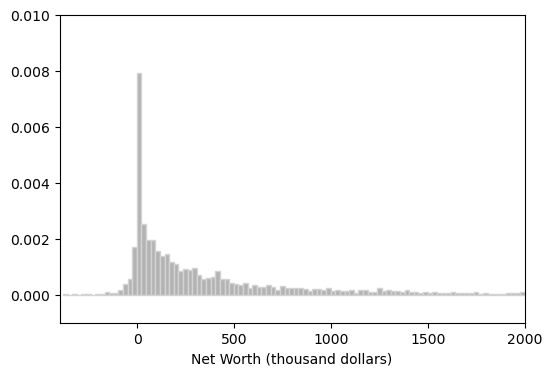

In [28]:
# 데이터 필터링
mask = (X >= -400) & (X <= 2000)  # [-400, 2000] 범위에 속하는 관측만 선택
X_filtered = X[mask]
w_filtered = w[mask]  # 가중치도 동일하게 필터링

# 히스토그램 그리기
plt.figure(figsize=(6, 4))
plt.xlabel('Net Worth (thousand dollars)')
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-400, 2000])
plt.ylim(-0.001, 0.010)
plt.show()

### SU 분포 Weighted MLE

$$\text{argmax} \sum_i w_i \log L(m,s,\lambda, \theta \mid x_i)$$

In [29]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -4.353749207460307 s_MLE = 14.875830115629578 lambda_MLE = 3.045945510181015 theta_MLE = 2.089705981181354
Objective function value at solution: 7.430483707764102


In [30]:
res_SU

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 7.430483707764102
        x: [-4.354e+00  2.700e+00  3.046e+00  7.370e-01]
      nit: 31
      jac: [-8.882e-08 -3.553e-07 -1.066e-06  1.243e-06]
     nfev: 170
     njev: 34
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

**평균 표준편차 왜도 첨도**

In [31]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 1059.457470450531
Weighted S.D.: 8085.433431879704
Weighted Skewness: 92.75847008732033
Weighted Kurtosis: 14517.33006547197


In [32]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 1380.9960373971508
S.D.: 12247.19698572734
Skewness: 712.5804967909689
Kurtosis: 39542847.94181715


### 히스토그램 vs. 모델 기반 PDF

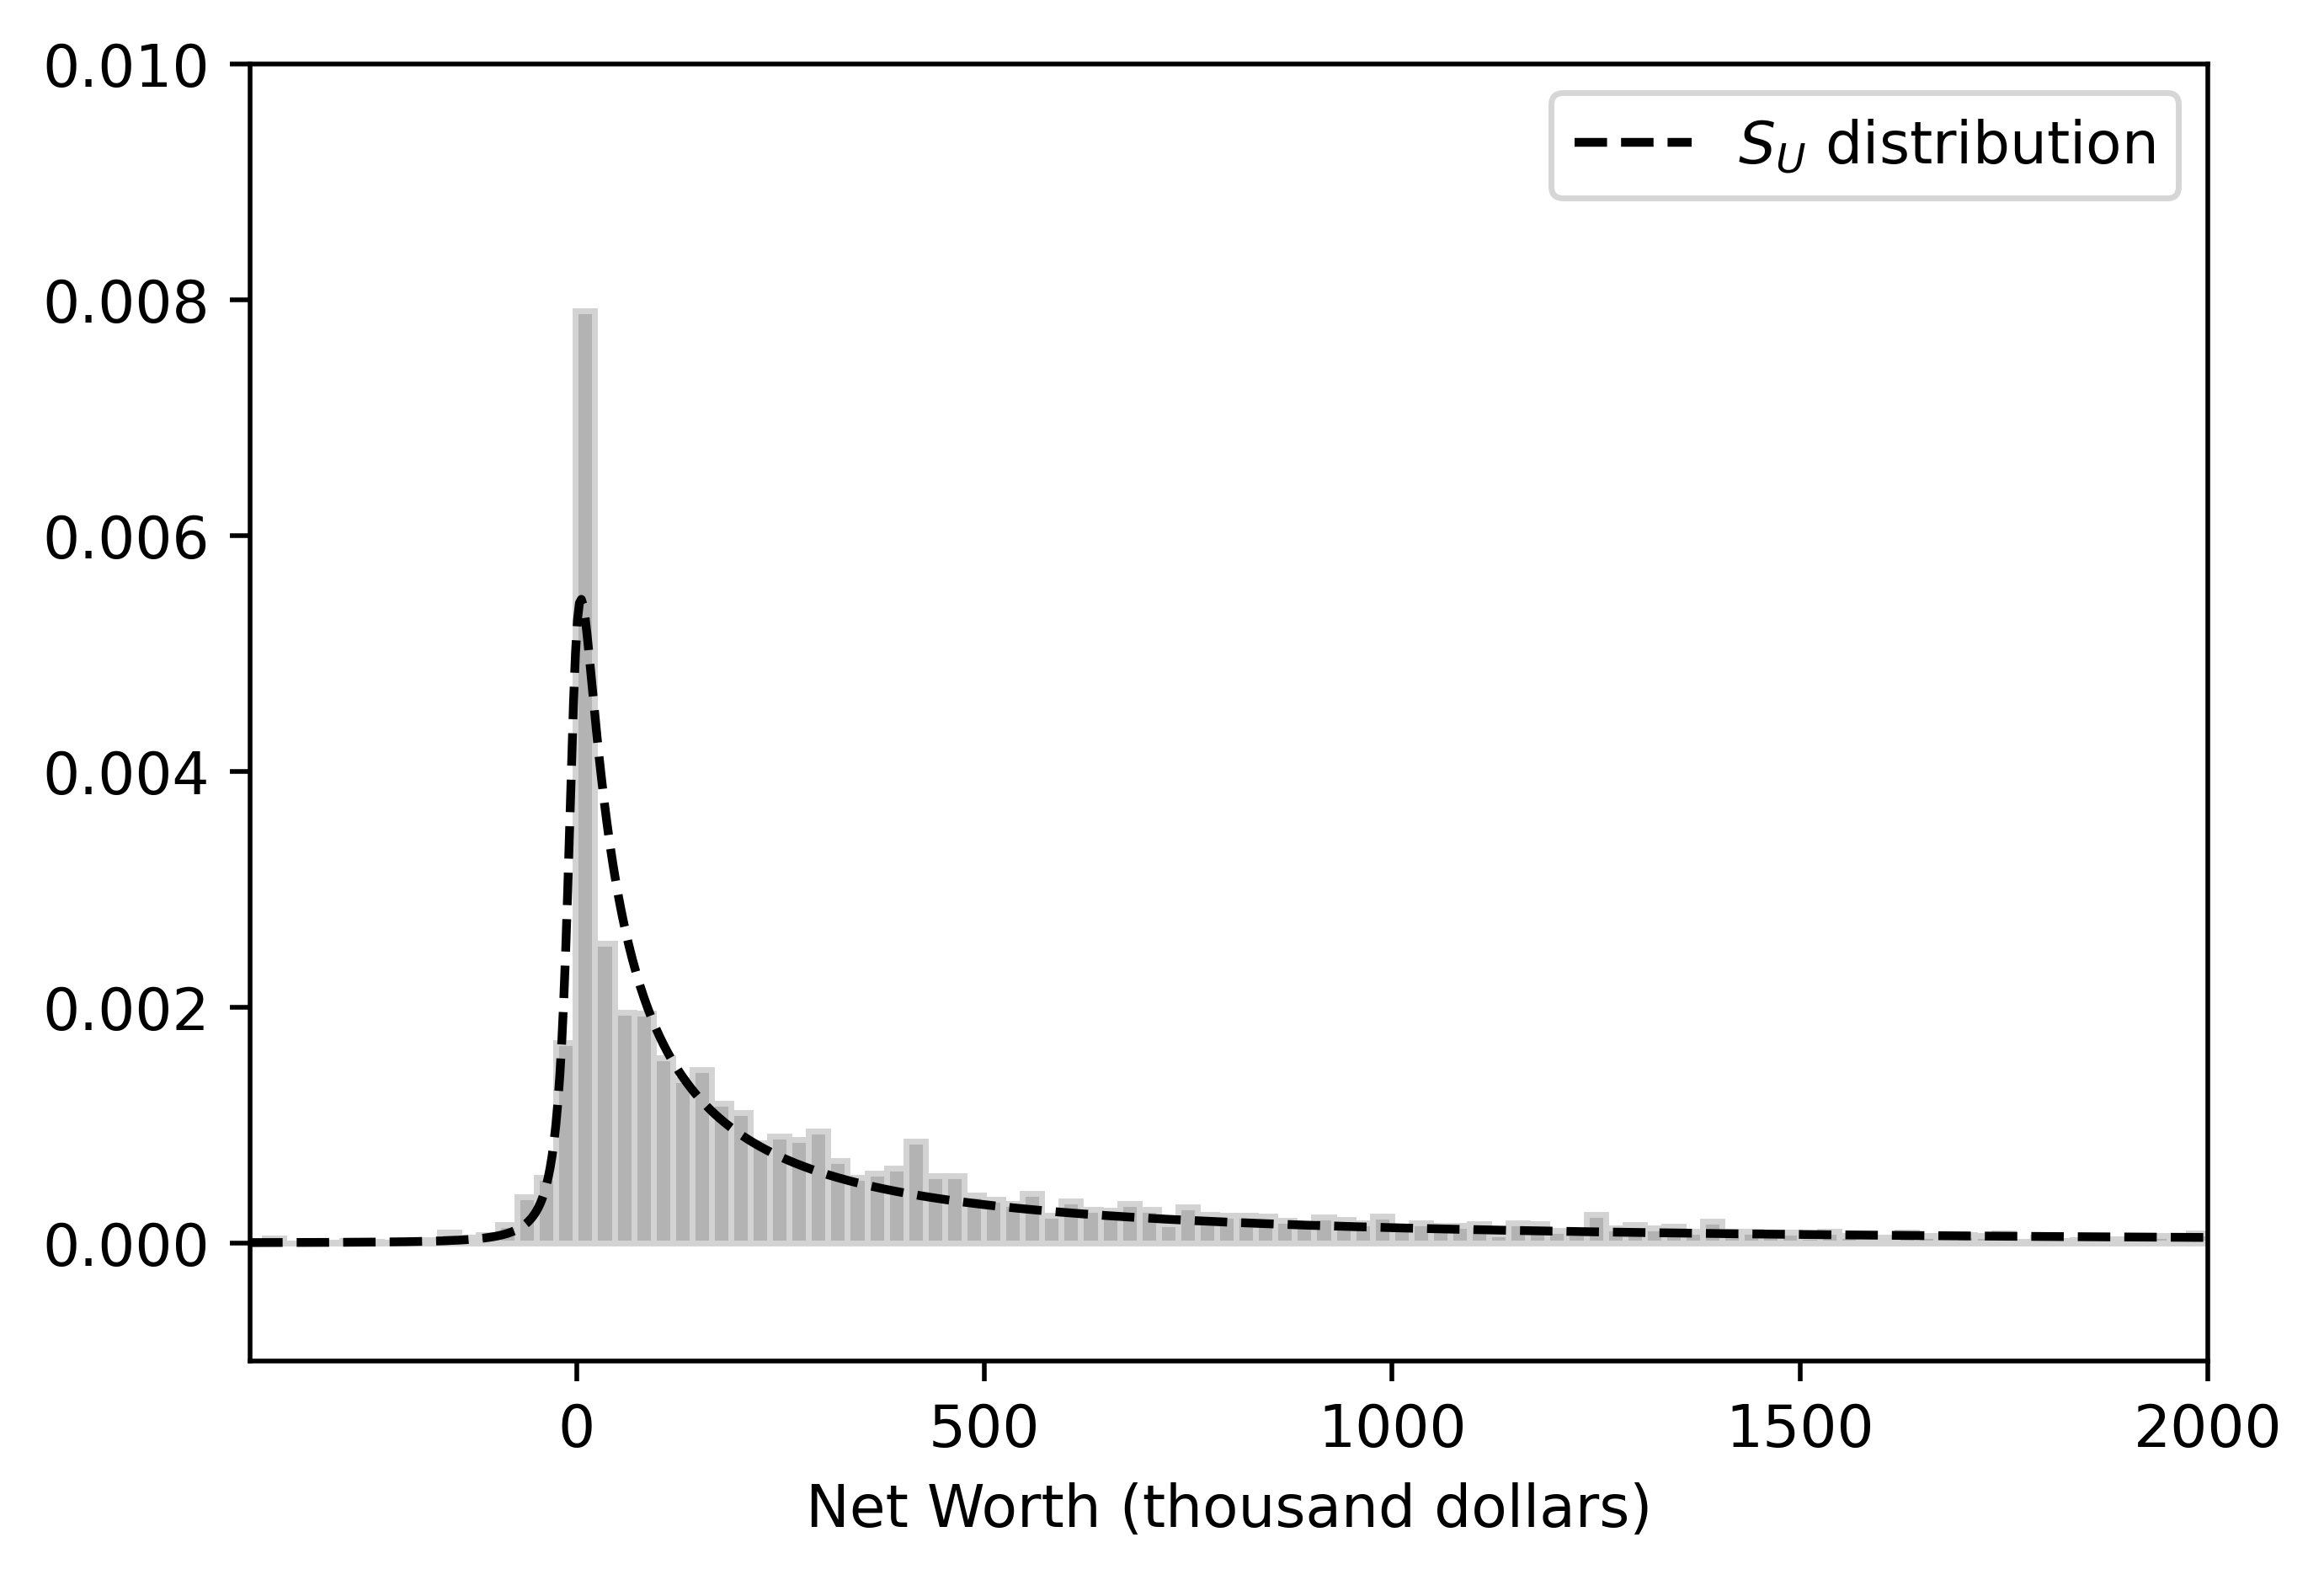

In [33]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Net Worth (thousand dollars)')

# 데이터 필터링
mask = (X >= -400) & (X <= 2000)  # [-400, 2000] 범위에 속하는 관측만 선택
X_filtered = X[mask]
w_filtered = w[mask]  # 가중치도 동일하게 필터링

# 히스토그램 그리기
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-400, 2000])
plt.ylim(-0.001, 0.010)

# Plot the MLE estimated distribution
dist_X = np.linspace(-400, 2000, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

**가중치 사용**

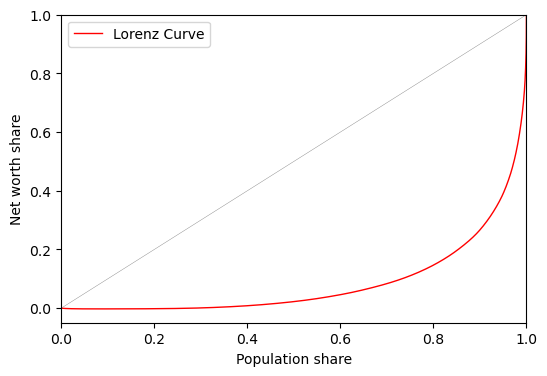

가중 Gini Coefficient: 0.8298


In [34]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

**Parametric Estimation 결과**

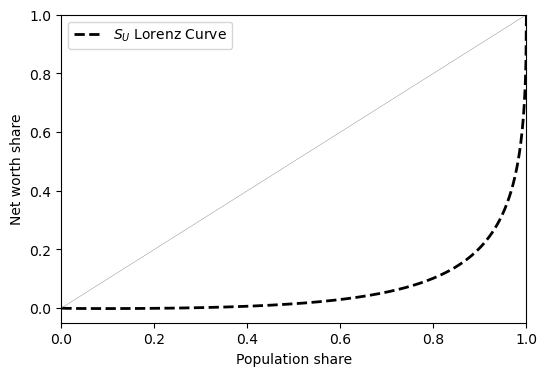

In [35]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

**지니계수 계산(수치 적분)**

In [36]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.8671225715403752

### 결과 비교

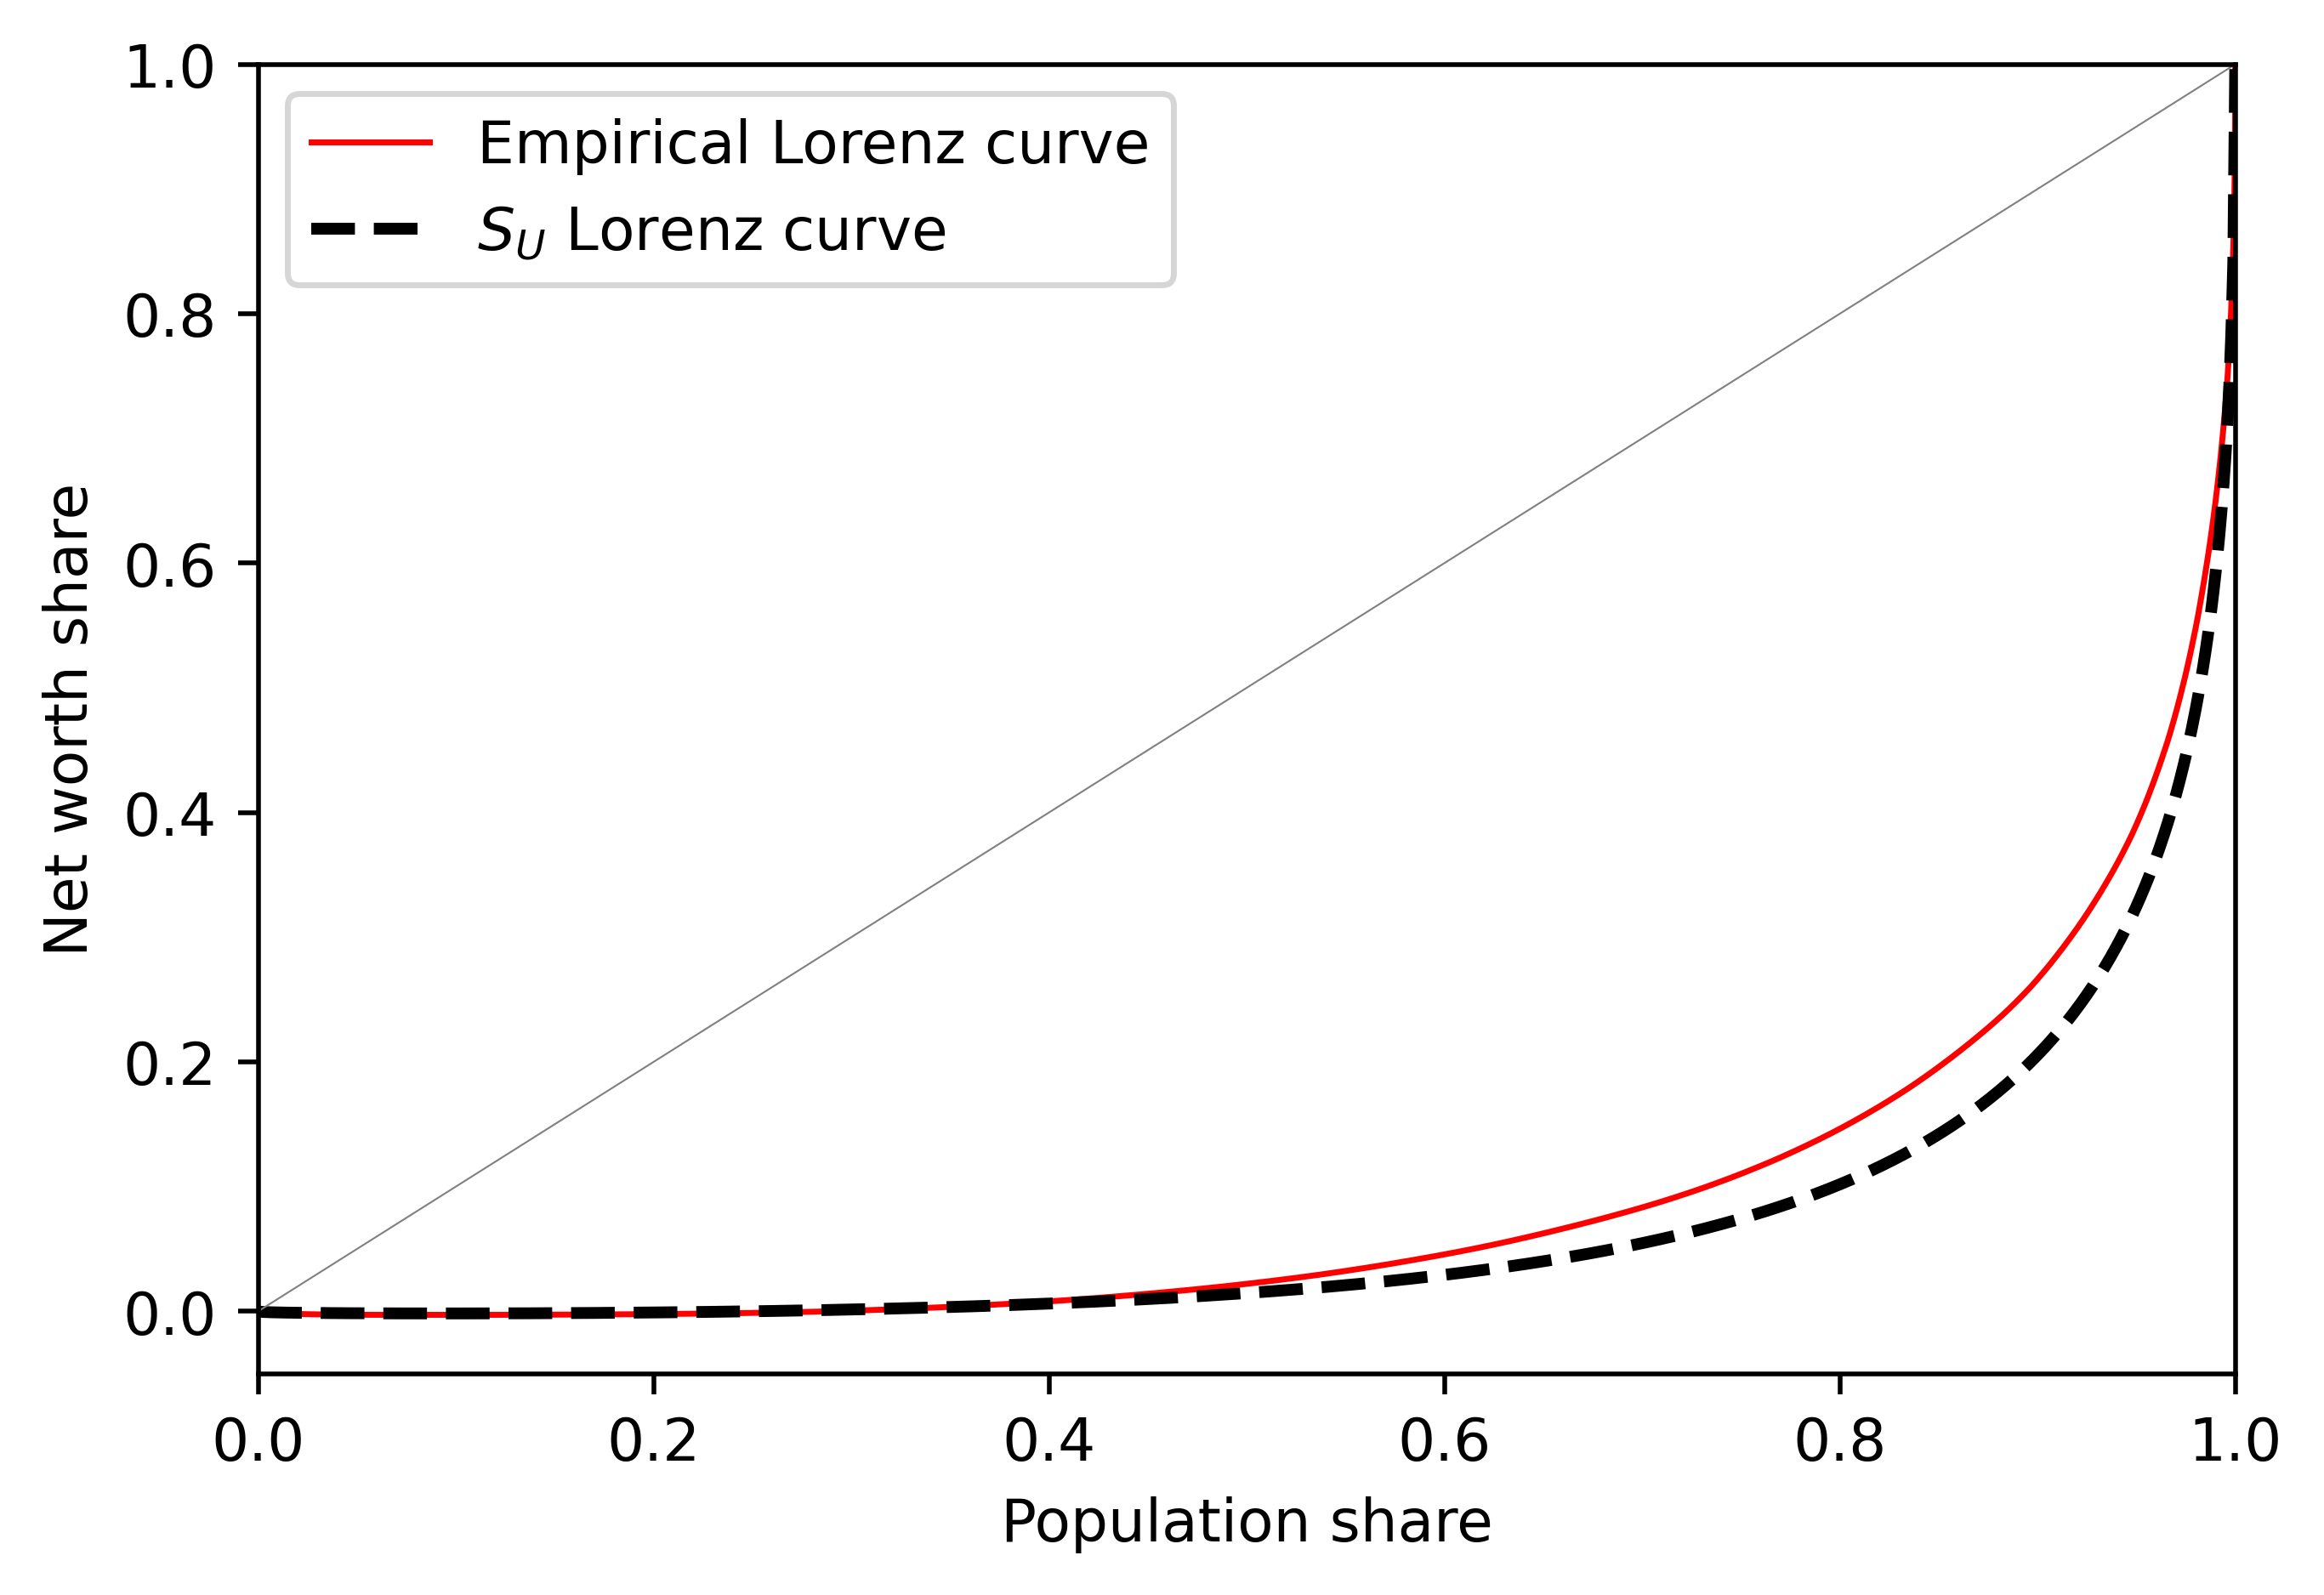

In [37]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

## 5 Income in 2022

In [38]:
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

In [39]:
X = income_2022
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count     22975.00
mean       1592.86
std       12442.71
min           0.00
25%          42.16
50%          94.04
75%         264.82
max      458230.95
Name: income, dtype: object

### 주요 통계량

In [40]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988867115881
Weighted S.D.: 727.9620604300843
Weighted Skewness: 166.76137348884768
Weighted Kurtosis: 63910.5666748011


**가중 지니계수**

In [41]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6068066016844815


**가중 히스토그램**

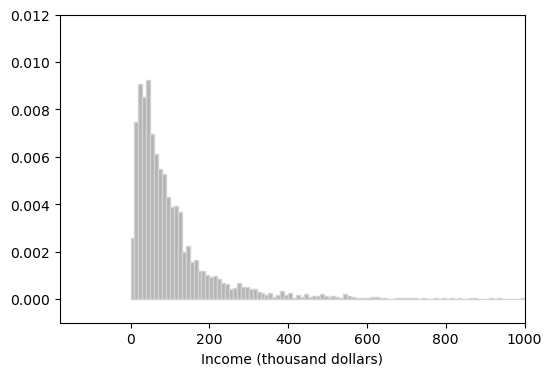

In [42]:
# 데이터 필터링
mask = (X >= -180) & (X <= 1000)
X_filtered = X[mask]
w_filtered = w[mask]  # 가중치도 동일하게 필터링

# 히스토그램 그리기
plt.figure(figsize=(6, 4))
plt.xlabel('Income (thousand dollars)')
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.001, 0.012)
plt.show()

### SU 분포 Weighted MLE 

In [43]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = 7.614629481975043 s_MLE = 10.954576510596073 lambda_MLE = 2.427072425919873 theta_MLE = 1.130466271104921
Objective function value at solution: 5.727623010890738


In [44]:
res_SU

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.727623010890738
        x: [ 7.615e+00  2.394e+00  2.427e+00  1.226e-01]
      nit: 36
      jac: [ 0.000e+00 -9.415e-06 -5.329e-06 -1.386e-05]
     nfev: 200
     njev: 40
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

**평균 표준편차 왜도 첨도**

In [45]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988867115881
Weighted S.D.: 727.9620604300843
Weighted Skewness: 166.76137348884768
Weighted Kurtosis: 63910.5666748011


In [46]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 124.22439359283459
S.D.: 189.53025842393495
Skewness: 8.945104758405455
Kurtosis: 291.7011057020838


### 히스토그램 vs. 모델 기반 PDF

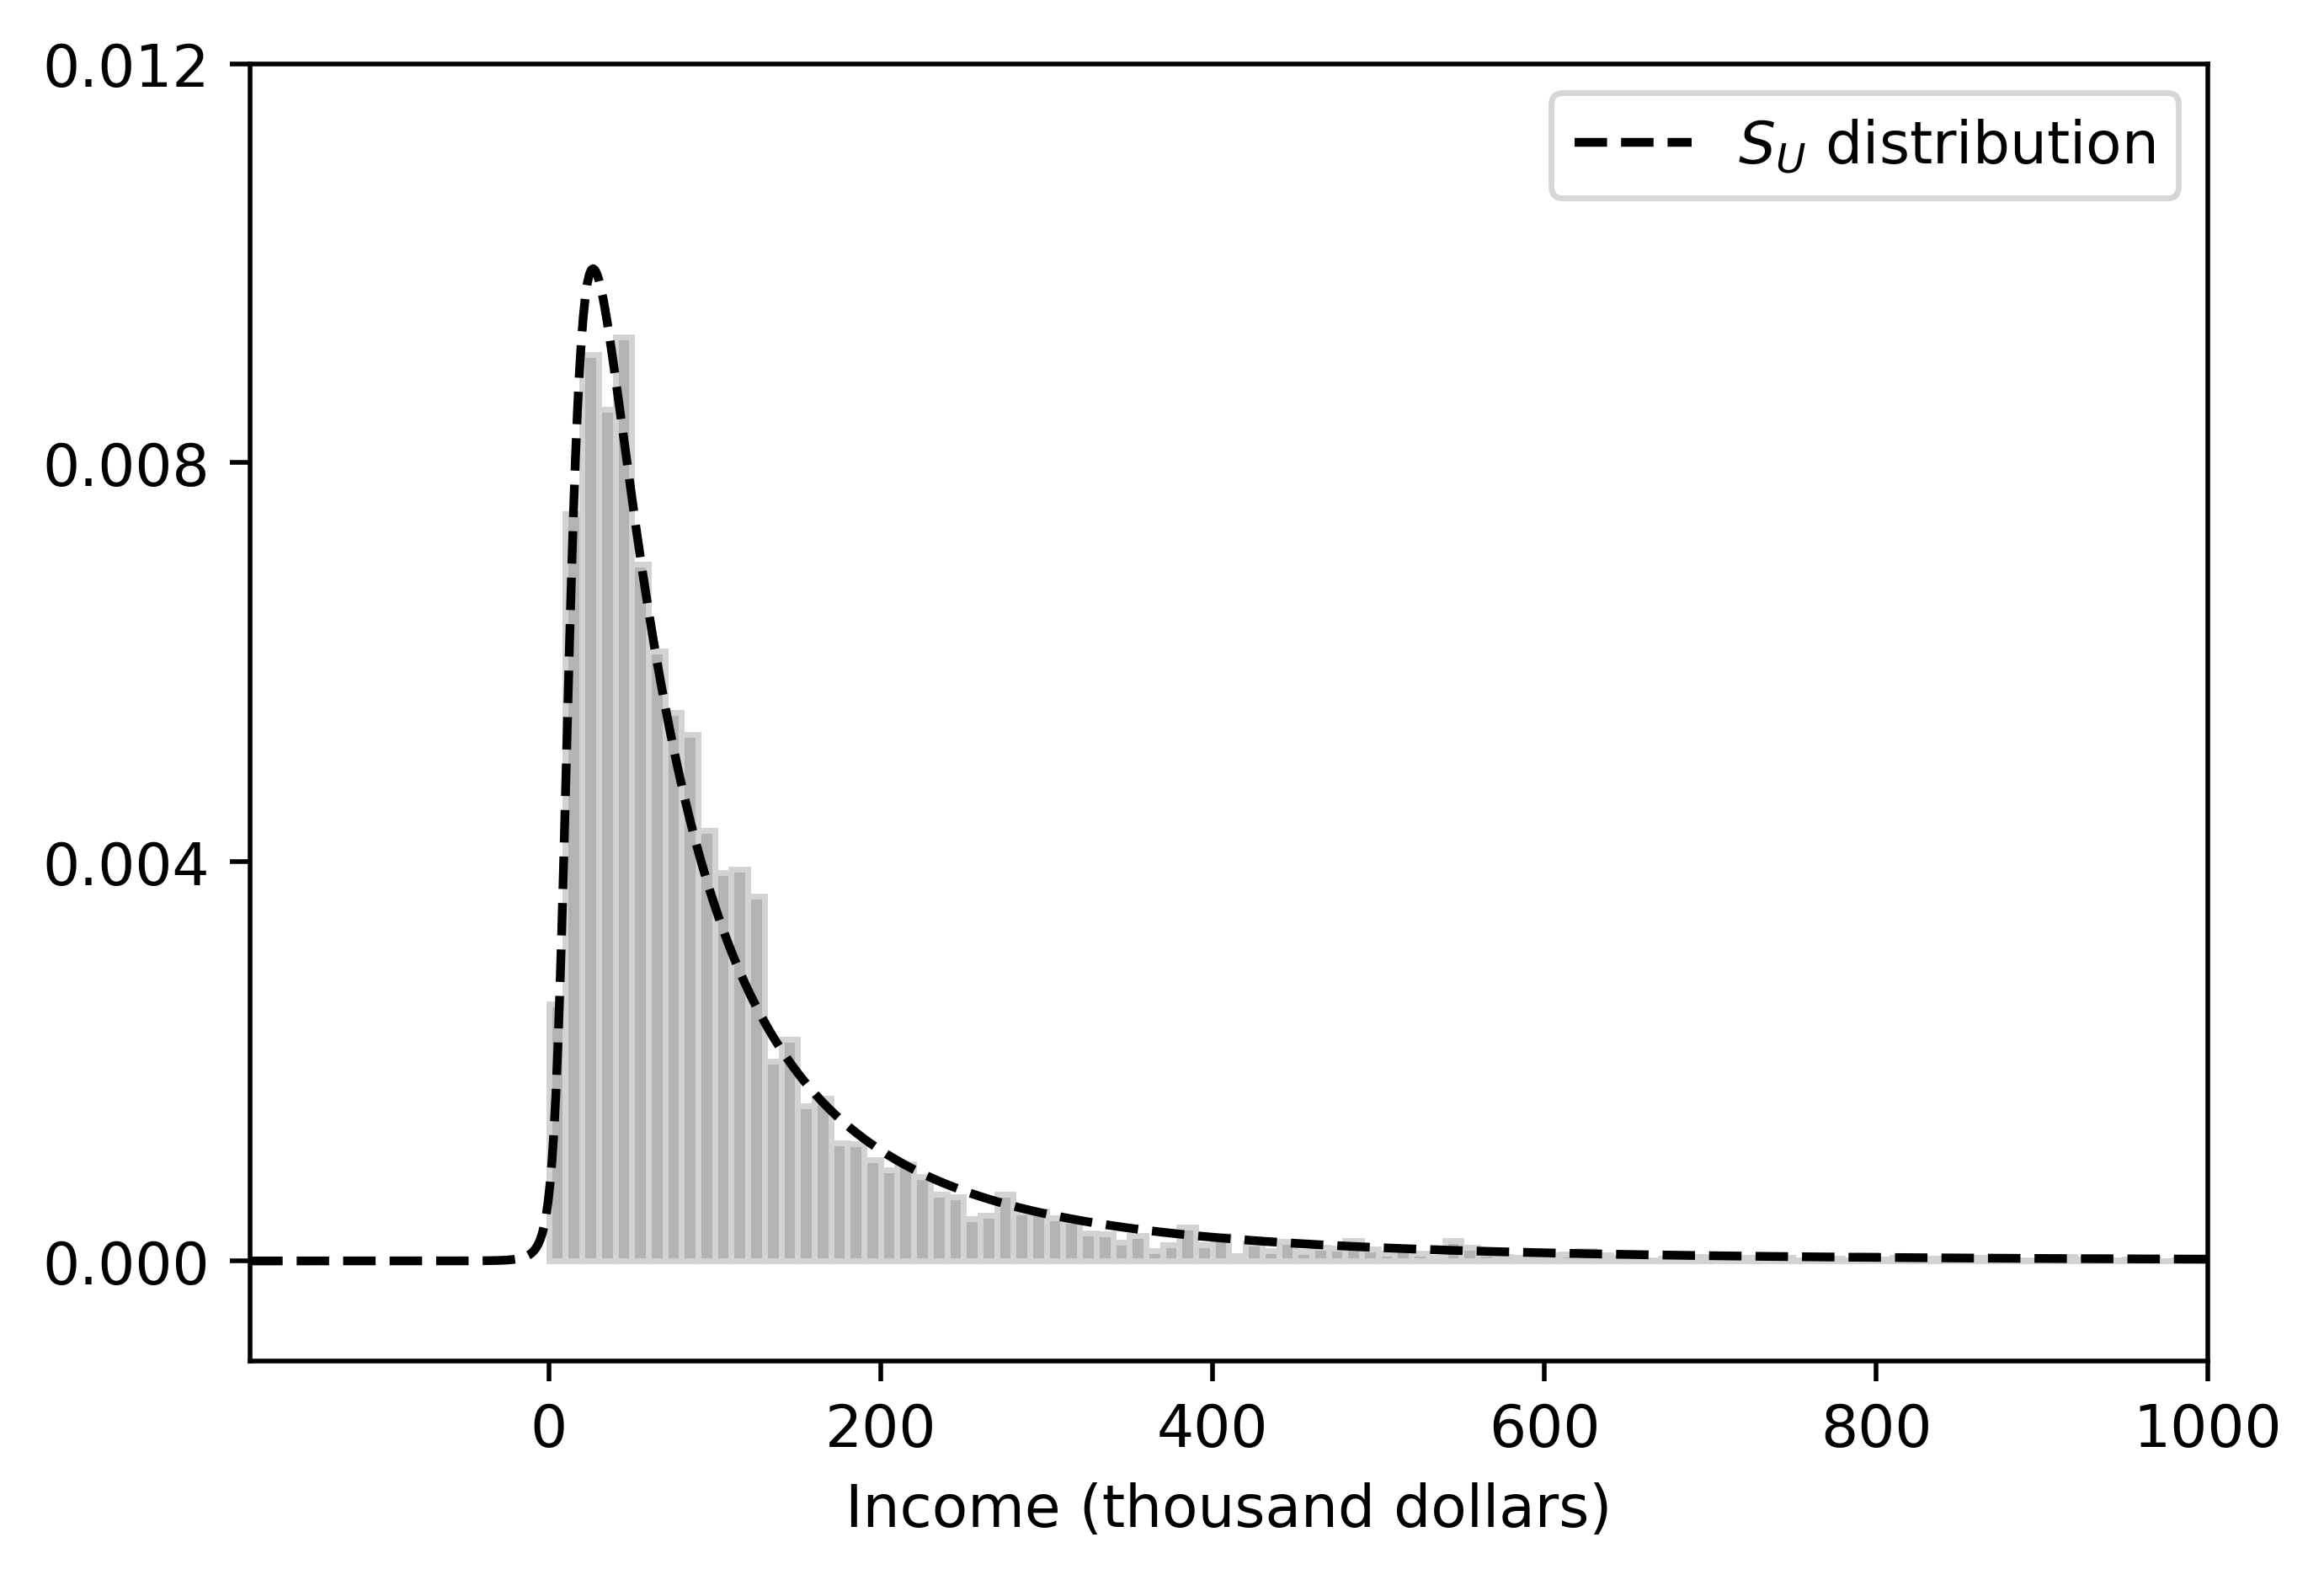

In [47]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (thousand dollars)')

# 데이터 필터링
mask = (X >= -180) & (X <= 1000)
X_filtered = X[mask]
w_filtered = w[mask]  # 가중치도 동일하게 필터링

# 히스토그램 그리기
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.001, 0.012)

# Plot the MLE estimated distribution
dist_X = np.linspace(-180, 1000, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.004, 0.008, 0.012])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

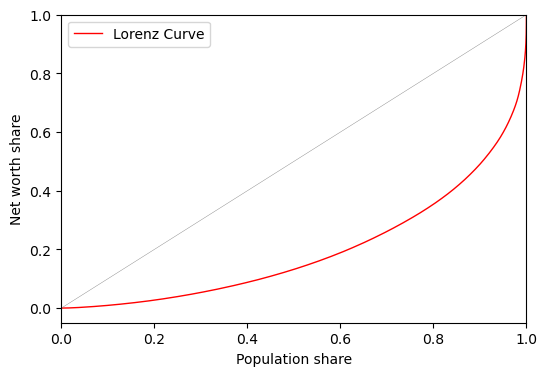

가중 Gini Coefficient: 0.6068


In [48]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

**Parametric Estimation 결과**

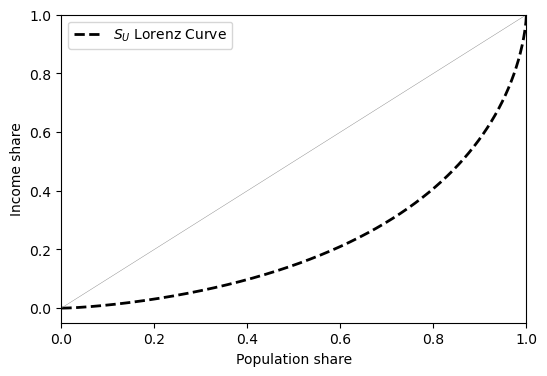

In [49]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

**지니계수 계산(수치 적분)**

In [50]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.5491117368397265

### 결과 비교

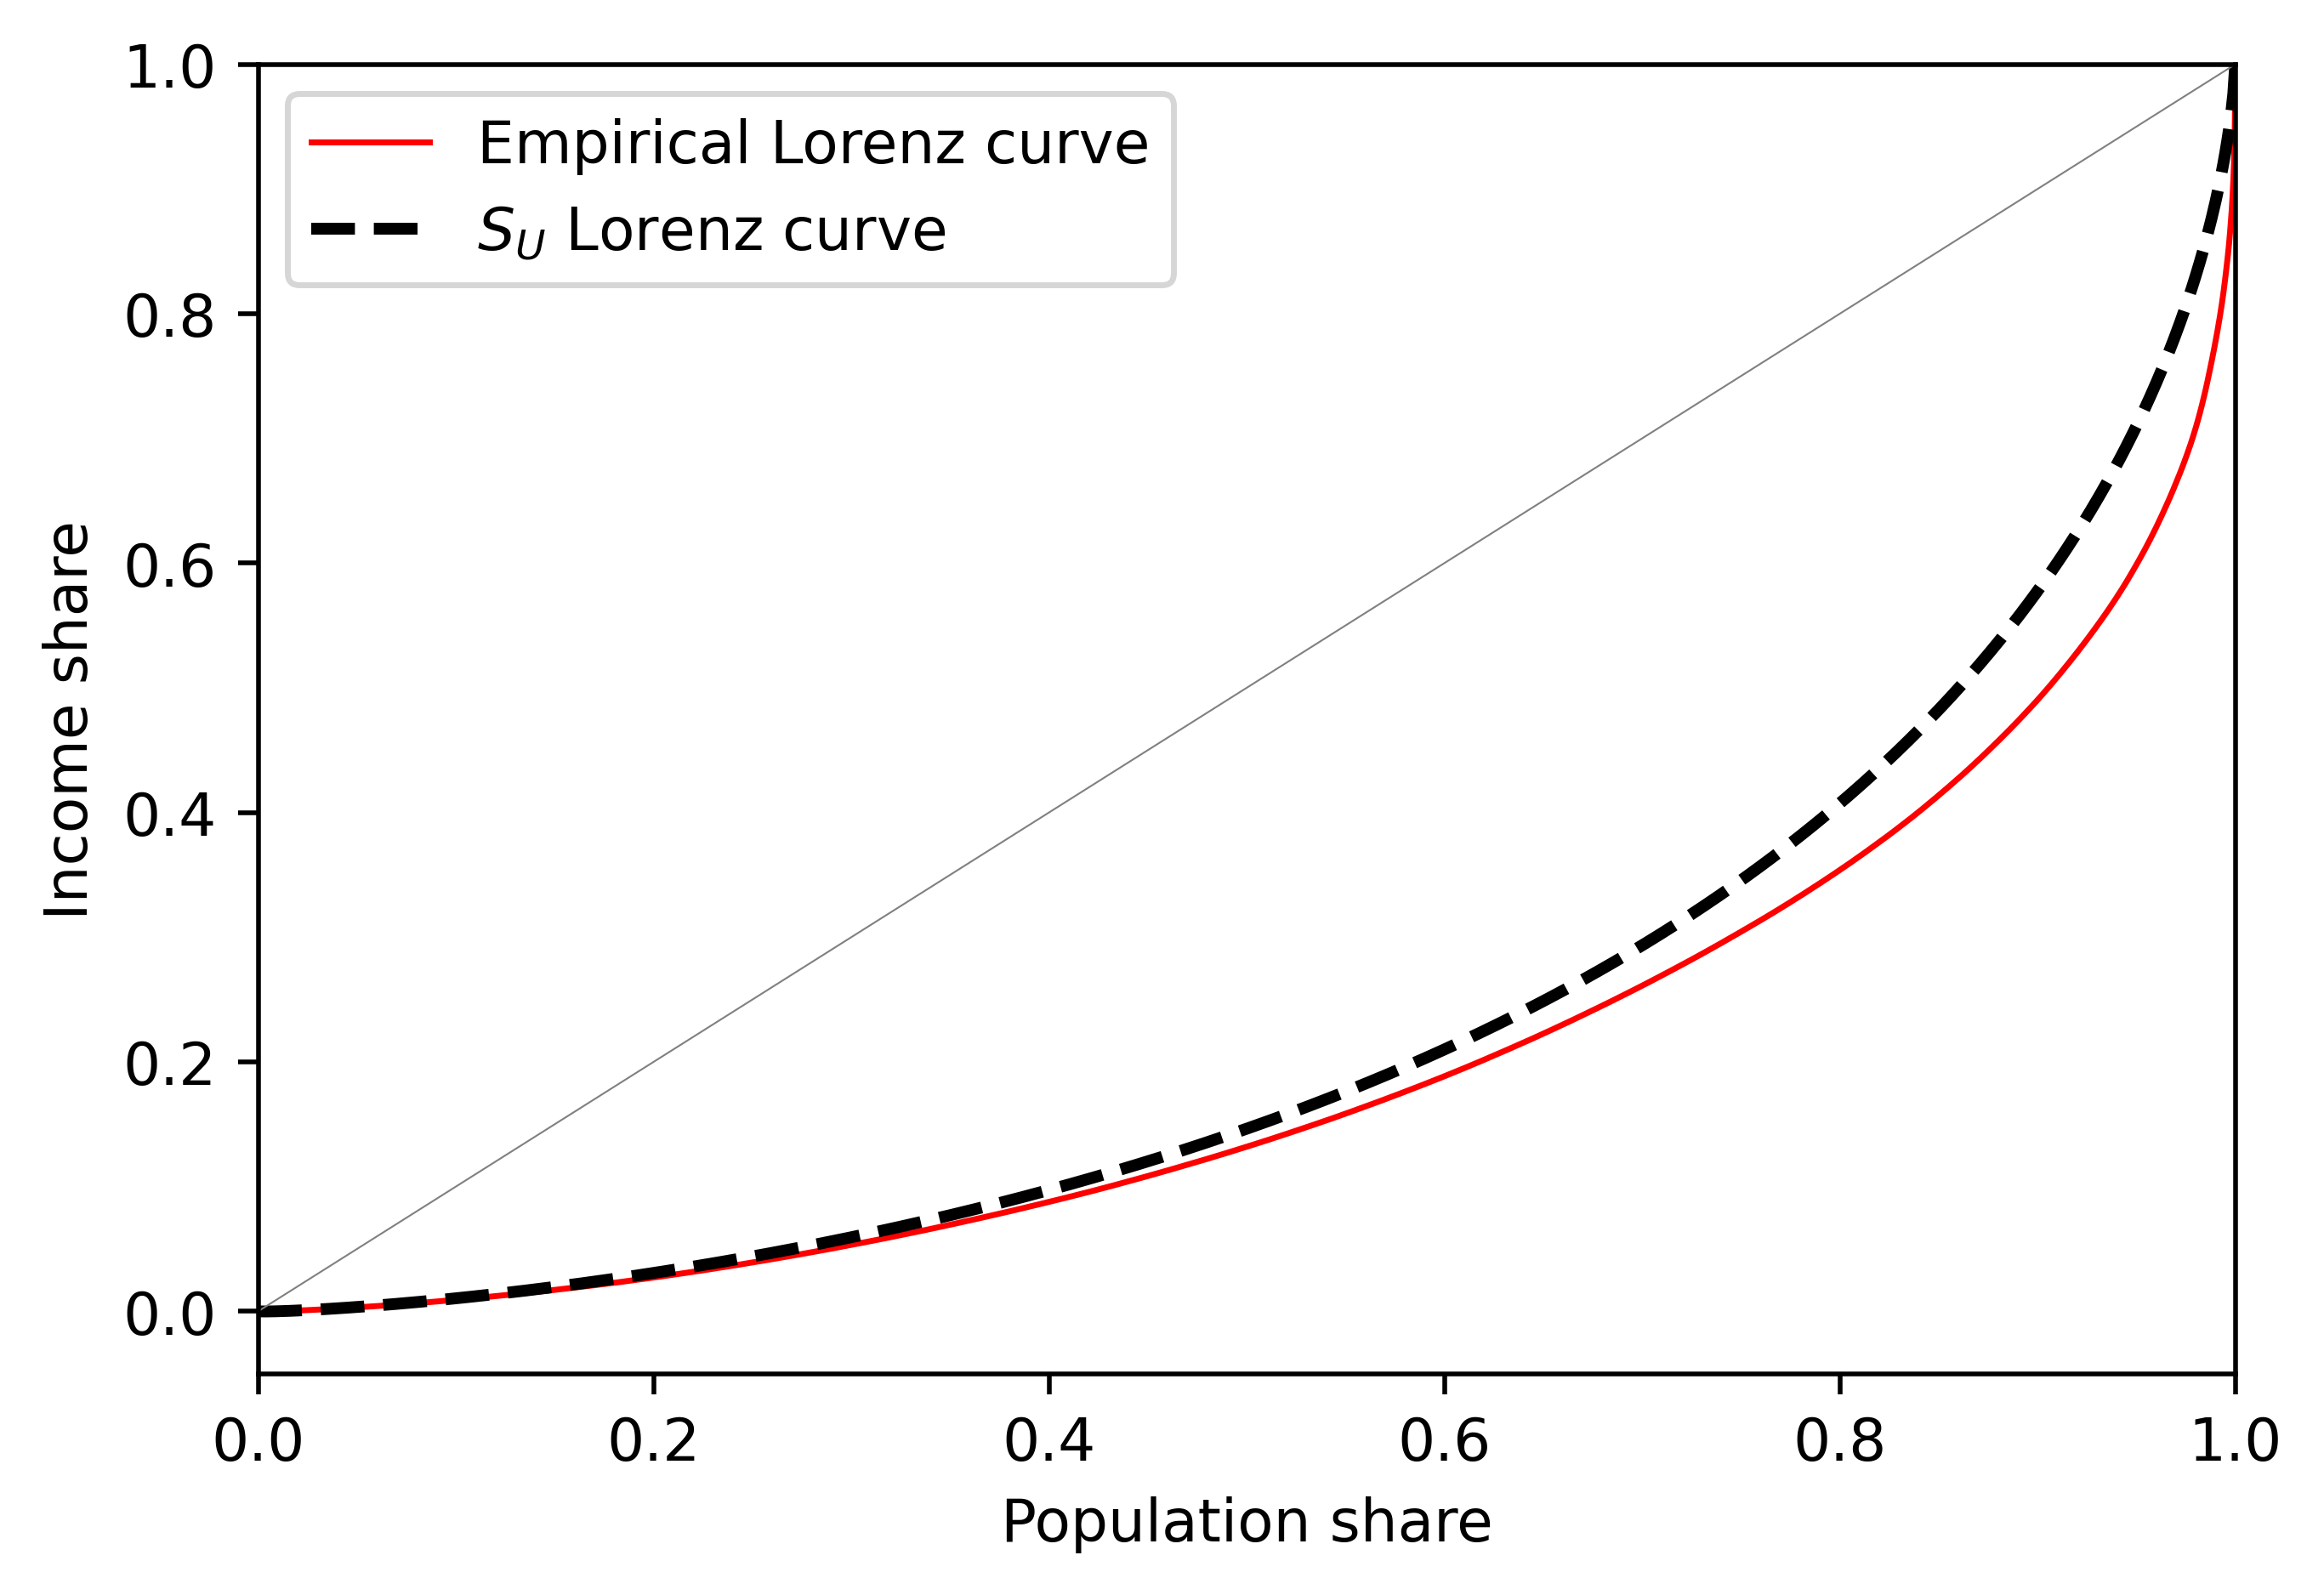

In [51]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

## 6 Income in 2022 with Log-normal

In [52]:
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

In [53]:
print('소득이 0인 가구', np.sum(income_2022 == 0)/5)
print('전체 가구', len(income_2022)/5)
print('소득이 0인 가구의 비중(%)', np.sum(income_2022 == 0)/len(income_2022)*100)

소득이 0인 가구 39.4
전체 가구 4595.0
소득이 0인 가구의 비중(%) 0.8574537540805224


In [54]:
X = income_2022.replace(0, 1e-5)
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count     22975.00
mean       1592.86
std       12442.71
min           0.00
25%          42.16
50%          94.04
75%         264.82
max      458230.95
Name: income, dtype: object

### 주요 통계량

In [55]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988871023287
Weighted S.D.: 727.962060422495
Weighted Skewness: 166.76137349390837
Weighted Kurtosis: 63910.56667743045


**가중 지니계수**

In [56]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6068066012415092


**가중 히스토그램**

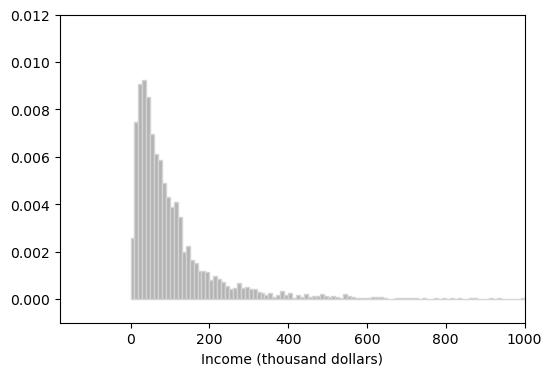

In [57]:
# 데이터 필터링
mask = (X >= -180) & (X <= 1000)
X_filtered = X[mask]
w_filtered = w[mask]  # 가중치도 동일하게 필터링

# 히스토그램 그리기
plt.figure(figsize=(6, 4))
plt.xlabel('Income (thousand dollars)')
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.001, 0.012)
plt.show()

### Log-normal 분포 Weighted MLE 

In [58]:
mu_init = 0
sigma_init = 0

params_init = np.array([mu_init, sigma_init])
res_LN = opt.minimize(weight_obj_LN_e, params_init, args=(X, w), method='L-BFGS-B')
mu_MLE, sigma_MLE = res_LN.x

sigma_MLE = np.exp(sigma_MLE)

print('mu_MLE =',mu_MLE, 'sigma_MLE =',sigma_MLE)
print("Objective function value at solution:", res_LN.fun)

mu_MLE = 4.21175826006971 sigma_MLE = 1.4272366593555585
Objective function value at solution: 5.986443965958112


In [59]:
res_LN

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.986443965958112
        x: [ 4.212e+00  3.557e-01]
      nit: 17
      jac: [-2.043e-06 -5.063e-06]
     nfev: 57
     njev: 19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

**평균 표준편차 왜도 첨도**

In [60]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988871023287
Weighted S.D.: 727.962060422495
Weighted Skewness: 166.76137349390837
Weighted Kurtosis: 63910.56667743045


In [61]:
print("Mean:", LN_mean(mu_MLE, sigma_MLE))
print("S.D.:", LN_var(mu_MLE, sigma_MLE)**0.5)
print("Skewness:", LN_skewness(mu_MLE, sigma_MLE))
print("Kurtosis:", LN_kurtosis(mu_MLE, sigma_MLE))

Mean: 186.8414695659069
S.D.: 482.4565966647683
Skewness: 24.96341122034233
Kurtosis: 4531.488434776198


### 히스토그램 vs. 모델 기반 PDF

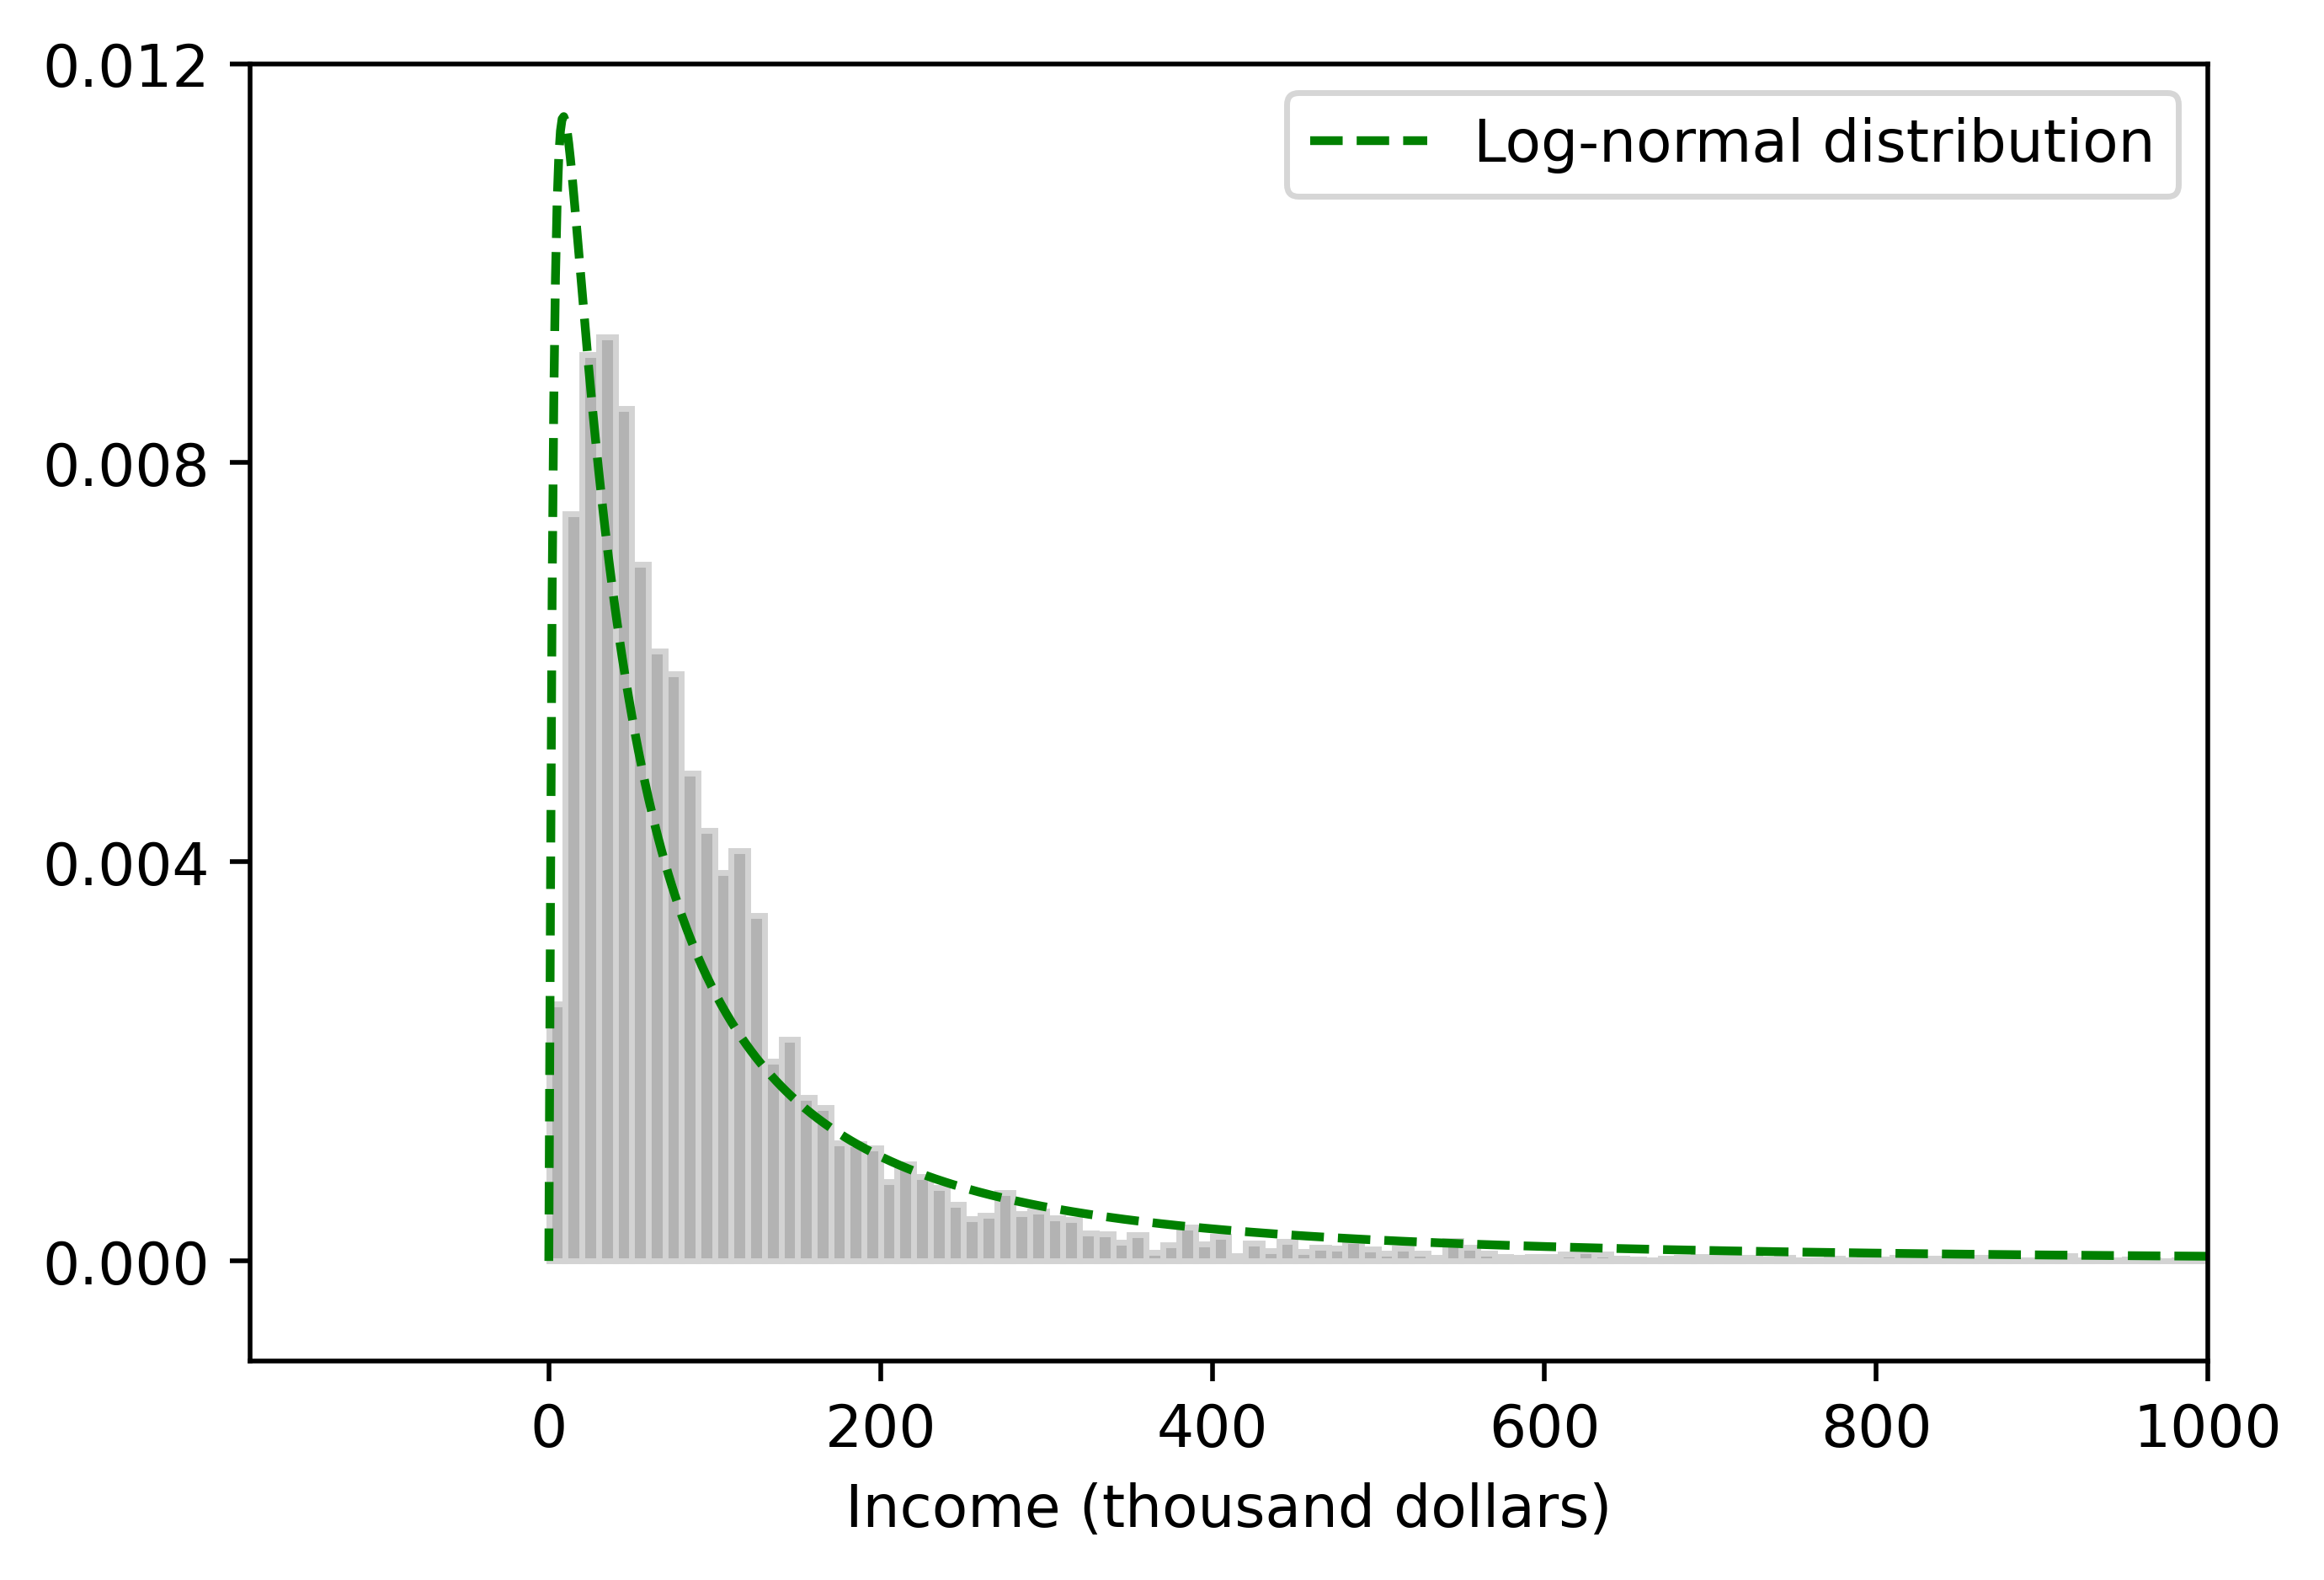

In [62]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (thousand dollars)')

# 데이터 필터링
mask = (X >= -180) & (X <= 1000)
X_filtered = X[mask]
w_filtered = w[mask]

# 히스토그램 그리기
num_bins = 100
plt.hist(X_filtered, num_bins, weights=w_filtered, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.001, 0.012)

# Plot the MLE estimated distribution
dist_X = np.linspace(1e-10, 1000, 1000)
plt.plot(dist_X, LN_pdf(dist_X, mu_MLE, sigma_MLE),
         linewidth=1.5, linestyle='dashed', color='g', label='Log-normal distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.004, 0.008, 0.012])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

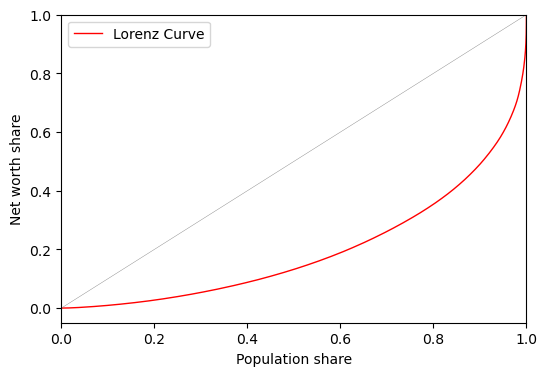

가중 Gini Coefficient: 0.6068


In [63]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

**Parametric Estimation 결과**

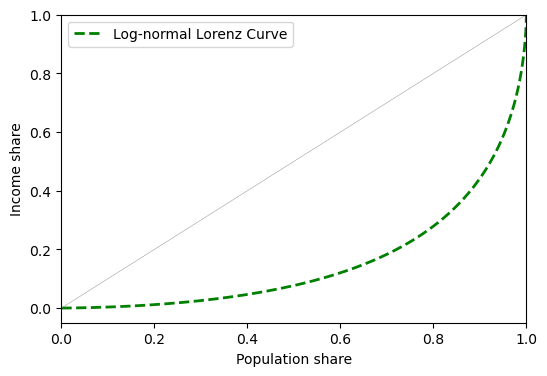

In [64]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_LN(dist_X, sigma_MLE),
         linewidth=2, linestyle='dashed', color='g', label='Log-normal Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

**지니계수**

$$
2\Phi\left(\frac{\sigma}{\sqrt{2}}\right) - 1
$$

In [65]:
gini = 2 * norm.cdf(sigma_MLE / np.sqrt(2)) - 1
gini

0.6871254545732142

**지니계수(수치 적분)**

In [66]:
from scipy.integrate import quad

res, err = quad(Lorenz_LN, 0, 1, args=(sigma_MLE))
1-2*res

0.6871254545985546

### 결과 비교

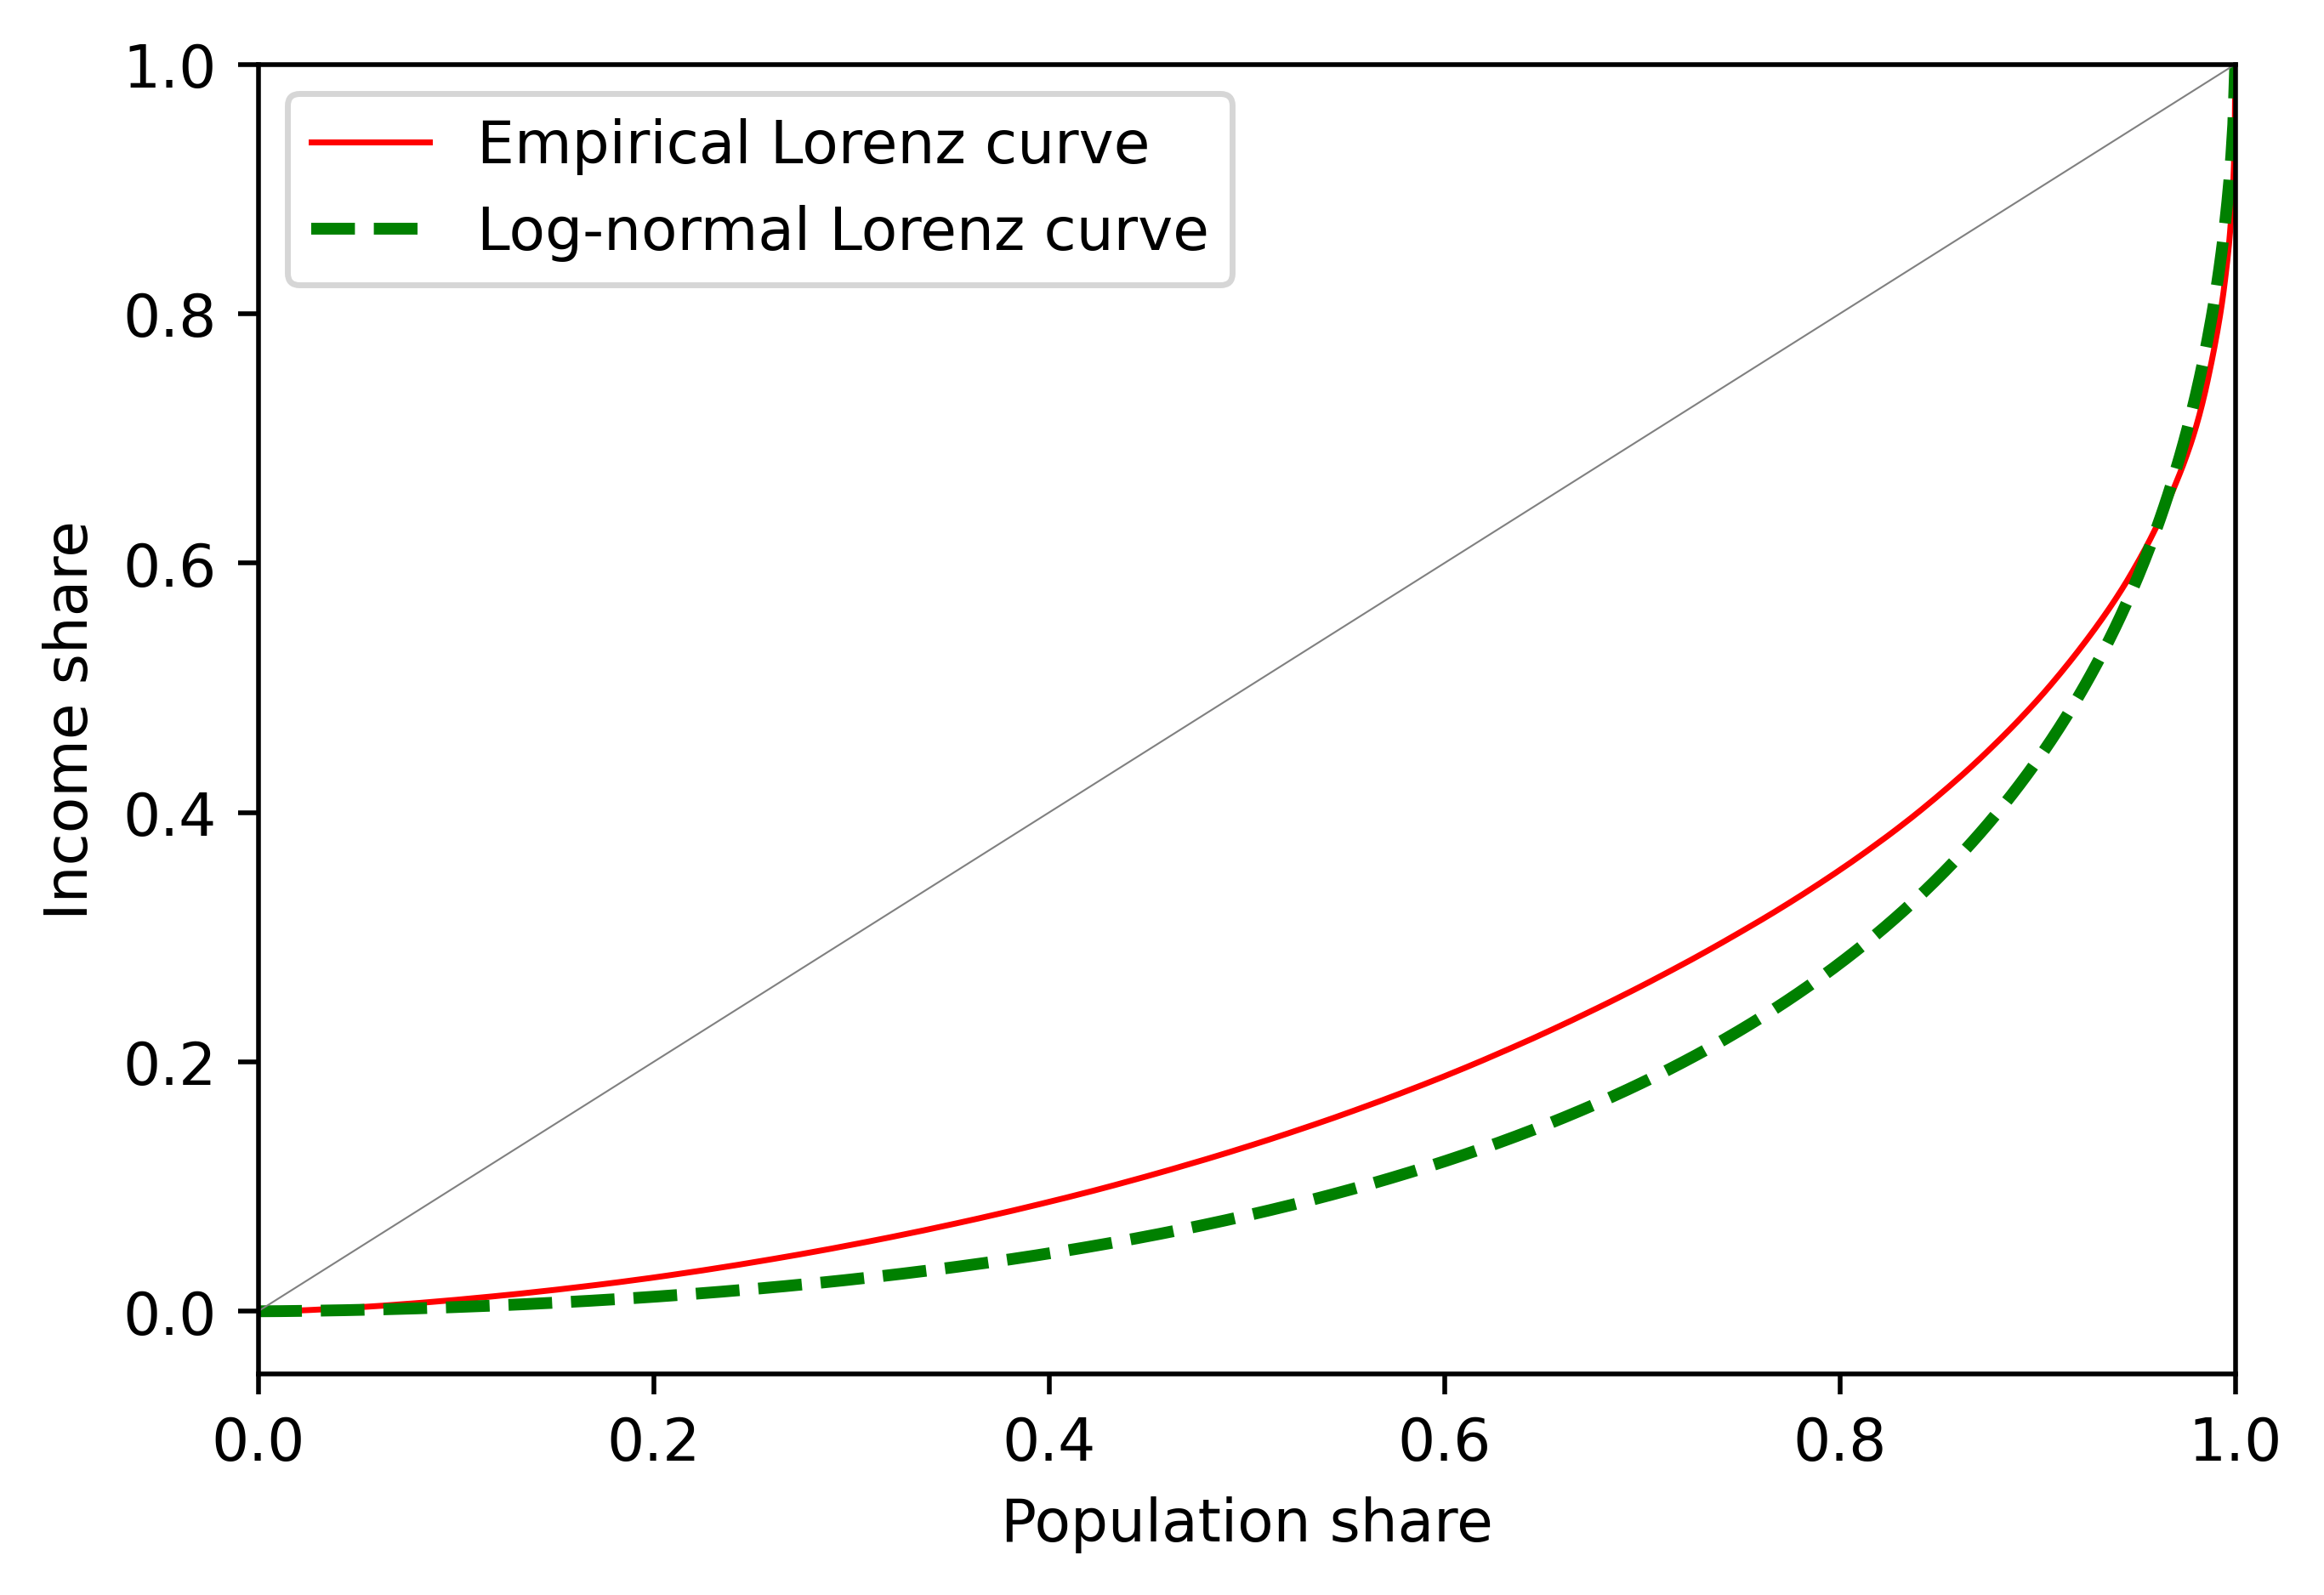

In [67]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_LN(dist_X, sigma_MLE),
         linewidth=2, linestyle='dashed', color='g', label='Log-normal Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

## 부록: scipy.opt.minimize 사용법

**파이썬에서 최대화(최소화) 문제를 설정하는 방법**

모든 최대화 문제는 최소화 문제로 다시 설정될 수 있다. 최소화 문제는 수치적으로 더 안정적이고 잘 정의되어 있기 때문에 대부분의 수치 최적화(numerical optimizer) 프로그램은 최소화 프로그램으로 설정된다. [scipy.optimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) 라이브러리에는 다양한 유형의 최소화 도구가 있다. 최대가능도 추정 문제의 경우, [scipy.optimize.minimize()](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 함수를 사용한다.

**`scipy.optimize.minimize()`**

줄여서 `opt.minimize()`이다. `opt.minimize()` 함수에는 3개의 필수 인수와 많은 옵션이 있다. 필수 인수는 다음과 같다.

1. `fun`: `opt.minimize()`의 첫 번째 인수는 목적함수로서 `opt.minimize()`는 목적함수를 최소화시키는 파라미터 값을 찾는다.
2. `x0`: 두 번째 인수는 파라미터 값에 대한 초기값이다.
3. `args=()`: 세 번째 인수는 목적함수를 계산하는 데 필요한 모든 객체 튜플이다.

**목적함수(objective function)**

목적함수는 `objective_function(params, *args)`의 형태이다.

- `params`: 첫 번째 파라미터는 스칼라 또는 값의 벡터이다. 이것은 목적함수를 최소화하기 위해 선택되는 값이다.

- `*args`: 두 번째 파라미터는 가변 길이(variable-length) 튜플 인수이다. 


**제약조건 하에서의 최소화**

`opt.minimize()` 함수에는 목적함수를 최소화하는 파라미터 값을 찾는 데 사용할 수 있는 많은 `method`가 있다. `method='MethodName'` 입력 인수를 사용하여 호출된다. 이들 중 일부는 선택되는 파라미터에 대해 상한 및 하한을 설정할 수 있는 제약조건 하에서의 최소화(bound-constrained minimization)를 허용한다. 이를 허용하는 방법은 `Nelder-Mead`, `L-BFGS-B`, `Powell`, `TNC` 등이다.